In [1]:
# Basis:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.xgboost.html


In [75]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [85]:
from darts.datasets import WeatherDataset
from darts.models import XGBModel

# from torchmetrics.regression import MeanSquaredError
# import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae, mse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
# torch.manual_seed(1)
np.random.seed(1)


/home/javier/.pyenv/versions/3.10.6/envs/bakery/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
series = WeatherDataset().load()


In [5]:
series.components


Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object', name='component')

In [6]:
series.freq


<10 * Minutes>

In [7]:
series.n_timesteps


52704

In [8]:
# Loading the dataset
data = pd.DataFrame(pd.read_csv('../raw_data/final_dataset.csv', index_col='index'))


In [9]:
df = data
df.shape


(45934, 19)

In [10]:
df.head()


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday
index,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0


In [11]:
df = df.reset_index()


In [12]:
df.head()


,index,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday
0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
1,2021-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2,2021-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
3,2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0
4,2021-01-01 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0


In [13]:
df['index'] = pd.to_datetime(df['index'])
df = df.set_index('index')
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45934 entries, 2021-01-01 00:00:00 to 2022-09-30 23:00:00
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   traditional_baguette       45934 non-null  float64
 1   croissant                  45934 non-null  float64
 2   coupe                      45934 non-null  float64
 3   pain_au_chocolat           45934 non-null  float64
 4   baguette                   45934 non-null  float64
 5   banette                    45934 non-null  float64
 6   cereal_baguette            45934 non-null  float64
 7   temperature_2m (°C)        45934 non-null  float64
 8   relative_humidity_2m (%)   45934 non-null  float64
 9   apparent_temperature (°C)  45934 non-null  float64
 10  precipitation (mm)         45934 non-null  float64
 11  rain (mm)                  45934 non-null  float64
 12  wind_speed_10m (km/h)      45934 non-null  float64
 13  wind_speed_

In [14]:
df.head()


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday
index,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0
2021-01-01 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0


In [15]:
# Remember to set the negative values to 0


In [16]:
series = TimeSeries.from_dataframe(df=df,freq='20min', fill_missing_dates=True, fillna_value=0)


In [17]:
series.columns


Index(['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'apparent_temperature (°C)',
       'precipitation (mm)', 'rain (mm)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'isHoliday'],
      dtype='object', name='component')

<Axes: xlabel='index'>

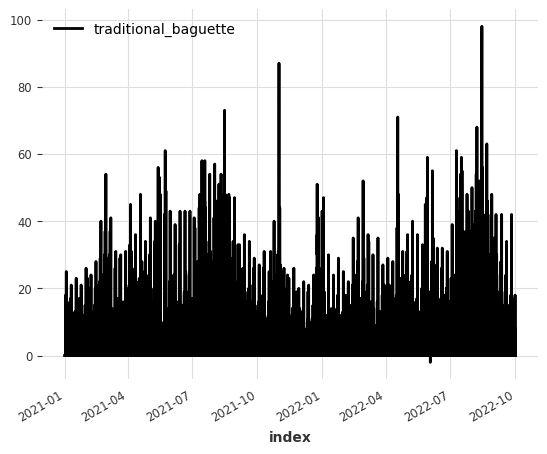

In [18]:
series['traditional_baguette'].plot()


In [19]:
# Differentiating
diff_series = series.diff()


In [20]:
# Scaling
# Instantiating the scaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)


In [21]:
scaled_series = ts_transformer.fit_transform(diff_series)


In [22]:
# Splitting the dataset in train and test
series_train, series_test = scaled_series.split_before(0.8)


In [23]:
len(series_train)


36745

In [24]:
# Defining target lists
target = series_train[['traditional_baguette',
                        'croissant',
                        'coupe',
                        'pain_au_chocolat',
                        'baguette',
                        'banette',
                        'cereal_baguette']][:13_140]


In [25]:
future_covariates = series_train[['temperature_2m (°C)',
                                   'relative_humidity_2m (%)',
                                   'apparent_temperature (°C)',
                                   'precipitation (mm)',
                                   'rain (mm)',
                                   'day_of_week_sin',
                                   'day_of_week_cos',
                                   'month_sin',
                                   'month_cos',
                                   'isHoliday']][:13_140]


In [26]:
past_covariates = series_train[['wind_speed_10m (km/h)',
                                 'wind_speed_100m (km/h)']][:13_140]


In [27]:
list_future_covariates=list(range(0,504))

# Prediction setup variables
days_predict = 7
interv_predict = days_predict*24*3  #504
lags_input = 14*24*3   # 1 year 26_280


In [28]:
# predict 504 unit sales values using the 12 pastmonth  values of all data, as well as the 7 days values
# corresponding to the forecasted period
model = XGBModel(
    lags=lags_input,   # 1 year back every 20 min
    lags_past_covariates=lags_input, # 1 year back every 20 min
    lags_future_covariates=list_future_covariates,
    output_chunk_length=interv_predict, # 1 yweek ahead every 20 min
)


In [ ]:
# training the model
model.fit(target, past_covariates=past_covariates, future_covariates=future_covariates)


# Finding out: Issue with targets

In [18]:
data_hourly = pd.read_csv('../raw_data/hourly_final_dataset.csv')


In [25]:
data_hourly['timestamp'] = pd.to_datetime(data_hourly['timestamp'])


In [26]:
data_hourly.set_index('timestamp', inplace=True)


In [41]:
data_hourly.head()


,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-1.4,97,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-0.1,97,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-0.9,97,-3.9,0.0,0.0,5.1,11.2,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 03:00:00,-1.5,97,-4.7,0.0,0.0,5.6,10.3,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,-1.4,97,-4.5,0.0,0.0,4.8,10.0,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
raw_targets_hourly = data_hourly[['traditional_baguette', 'croissant']].groupby(data_hourly.index.date).sum()


In [44]:
raw_targets_hourly.index[0]


datetime.date(2021, 1, 1)

In [103]:
raw_targets_hourly[(raw_targets_hourly.index >= pd.to_datetime('2022-06-09').date())
                   & (raw_targets_hourly.index <= pd.to_datetime('2022-06-17').date())]


,traditional_baguette,croissant
2022-06-09,126.0,29.0
2022-06-10,117.0,19.0
2022-06-11,218.0,62.0
2022-06-12,244.0,87.0
2022-06-13,119.0,20.0
2022-06-14,130.0,24.0
2022-06-15,136.0,23.0
2022-06-16,115.0,23.0
2022-06-17,120.0,17.0


<Axes: >

<Figure size 2000x500 with 0 Axes>

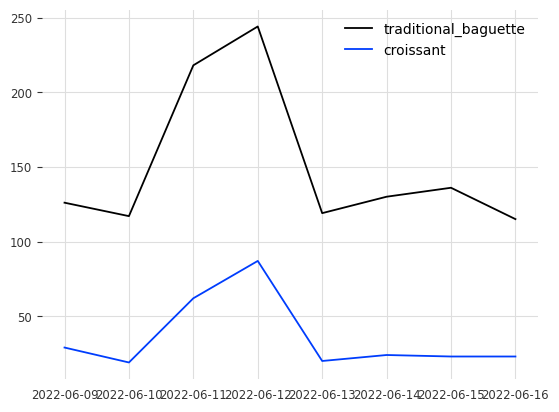

In [94]:
plt.figure(figsize=(20,5))
test_plot = raw_targets_hourly[pd.to_datetime('2022-06-09').date():pd.to_datetime('2022-06-16').date()];
test_plot.plot()


## Checking the normalized dataset

In [80]:
data_hourly.head(3)


,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-1.4,97,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-0.1,97,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-0.9,97,-3.9,0.0,0.0,5.1,11.2,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
ts_hourly = TimeSeries.from_dataframe(df=data_hourly,freq='60min', fill_missing_dates=True, fillna_value=0)


In [89]:
ts_hourly.columns


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday',
       'traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [90]:
# Scaling
# Instantiating the scaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)


In [91]:
scaled_ts = ts_transformer.fit_transform(ts_hourly)


In [83]:
data_hourly_scaled.


array([[0.09598214, 0.96385542, 0.14141414, ..., 0.        , 0.03921569,
        0.07142857],
       [0.125     , 0.96385542, 0.17171717, ..., 0.        , 0.03921569,
        0.07142857],
       [0.10714286, 0.96385542, 0.15757576, ..., 0.        , 0.03921569,
        0.07142857],
       ...,
       [0.45089286, 0.48192771, 0.45252525, ..., 0.        , 0.03921569,
        0.07142857],
       [0.42857143, 0.61445783, 0.43030303, ..., 0.        , 0.03921569,
        0.07142857],
       [0.41517857, 0.72289157, 0.42020202, ..., 0.        , 0.03921569,
        0.07142857]])